### This recurrent neural network (RNN), without torch.nn.rnn, solves the country-from-surname problem, by character-level hidden state prediciton. Works!

In [18]:
import io
import os
import unicodedata
import string
import glob
import torch
import random
import matplotlib.pyplot as plt

# Learned a lot from: https://github.com/python-engineer

In [10]:
# Load and preprocess data

vocab = string.ascii_letters + " .,;'"
n = len(vocab)

labels = []
examples = {}

for file in glob.glob('data/names/*.txt'):  # for all files

    # Use filename as label for examples in dictionary
    label = os.path.splitext(os.path.basename(file))[0]
    labels.append(label)

    words = []

    text = io.open(file, encoding='utf-8').read().strip().split('\n')

    # normalize text
    for word in text:
        words.append(''.join(char for char in unicodedata.normalize('NFD', word) if   unicodedata.category(char) != 'Mn' and char in vocab))

    examples[label] = words

In [11]:
# One-hot encoding

# Character-level
def char_2_tensor(char):
    tensor = torch.zeros(1,n)
    tensor[0][vocab.find(char)] = 1
    return tensor

# String-level
def string_2_tensor(string):
    tensor = torch.zeros(len(string), 1, n)
    for i, char in enumerate(string):
        tensor[i][0][vocab.find(char)] = 1
    return tensor

def out_to_label(out):
    return labels[torch.argmax(out).item()]

def random_sample(examples, labels):

    (label,l_examples)=random.choice(list(examples.items()))
    example=random.choice(l_examples)

    # return example, label (on tensor form)
    return string_2_tensor(example), torch.tensor([labels.index(label)], dtype=torch.long)

#random_sample(examples, labels)

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0.,

In [12]:
# RNN model class

import torch
import torch.nn as nn
import matplotlib as plt

class MyRNN(nn.Module):
    # without nn.rnn
    def __init__(self,input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()

        self.hidden_size = hidden_size
        
        # Combine input and hidden state
        self.i_to_h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h_to_o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden_state):
        # Concatenate x and hidden stat as inut
        hidden_out = self.i_to_h(torch.cat((x, hidden_state), 1))
        out = self.h_to_o(torch.cat((x, hidden_state), 1))
        out = self.softmax(out)

        return out, hidden_out

    def init_hidden(self): # initial hidden state
        return torch.zeros(1, self.hidden_size)

In [13]:
n_labels = len(labels)

# Instantiate model, hidden_size set to 128
model = MyRNN(n, 128, n_labels)

# One step in model
in_1 = char_2_tensor('A')
hidden_1 = model.init_hidden()

out, next_hidden = model(in_1, hidden_1)
print(out)
print(next_hidden.size())


tensor([[-2.8426, -2.9036, -2.9189, -2.8896, -2.8264, -2.8672, -2.8297, -3.0046,
         -2.9177, -2.8649, -2.8137, -2.9491, -2.9548, -2.9521, -2.8658, -2.9951,
         -2.8929, -2.7722]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 128])


In [47]:
# One step for a string in model

in_str_1 = string_2_tensor('Chow')
hidden_str_1 = model.init_hidden()

out, next_hidden = model(in_str_1[0], hidden_str_1)
print(out)
print(f'Predicted label: {labels[torch.argmax(out).item()]}')
print(next_hidden.size())

tensor([[-2.8997, -2.8891, -2.6895, -2.9602, -2.5142, -2.8003, -2.4817, -4.0866,
         -2.9897, -3.5689, -3.2615, -2.1776, -3.2176, -3.4886, -2.9186, -3.0331,
         -3.0809, -2.5425]], grad_fn=<LogSoftmaxBackward>)
Predicted label: Korean
torch.Size([1, 128])


In [15]:
# Training

loss_crit = nn.NLLLoss() # Define loss
optim = torch.optim.SGD(model.parameters(), lr=0.005)

n_training_examples = 100000
acc_loss = 0
mean_loss = []

for i in range(n_training_examples):   # Main training loop
    hidden = torch.zeros(1, model.hidden_size)             # init hidden state

    example, label = random_sample(examples, labels)

    for x in example:
        out, hidden = model(x, hidden) # acc. hidden state over the whole example

    loss = loss_crit(out, label) # get the example loss from last model out (last x in example)
    acc_loss += loss.item()

    optim.zero_grad()            # reset gradients for next optimization
    loss.backward()
    optim.step()

    if (i+1) % 1000 == 0:  # acc. mean loss to measure training progress
        mean_loss.append(acc_loss/1000)
        acc_loss = 0

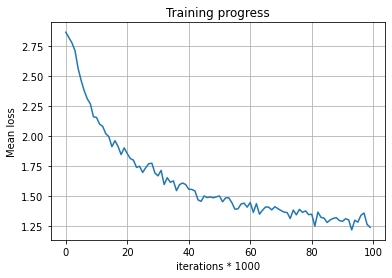

In [22]:
plt.figure()
plt.plot(mean_loss)
plt.title('Training progress')
plt.ylabel('Mean loss')
plt.xlabel('iterations * 1000')
plt.grid()
plt.show()

In [35]:
# Predictions on trained model

def model_pred(example):
    example = string_2_tensor(example)
    with torch.no_grad():
        hidden = torch.zeros(1, model.hidden_size) # initialize hidden state
        for x in example:
            out, hidden = model(x, hidden)
            
        return labels[torch.argmax(out)]

### Finally, predict some names:

In [46]:
print(f'Watson is {model_pred("Watson")}')

Watson is Scottish


In [40]:
print(f'Zhang is {model_pred("Zhang")}')

Zhang is Chinese


In [41]:
print(f'Bolshunov is {model_pred("Bolshunov")}')

Bolshunov is Russian
